#Histopathologic Cancer Detection
By Sheraz Mahmood


The following is a study of Convolutional Neural Network hyperparameter tuning with respect to VGGNet and ResNet architectures.

> Add blockquote



# Brief Description of Problem and Data

Cancer is a global health crisis, causing millions of deaths each year.  Early and accurate detection is critical to improve survival rates, especially for agressive forms like breast cancer.  Pathologist worklaods are intense and error prone.  A pathologist are sugest to fatigue and subjectivity which can lead to inconsistent or incorrect diagnoses.

We're studying this dataset to build deep learning models that can detect cancerous tissue in medical images. Doing so can aid early detection, reduce diagnostic workload, and ultimately save lives — especially in areas where medical experts are scarce.

Dataset From: https://www.kaggle.com/competitions/histopathologic-cancer-detection

This project focuses on using two well known architectures: VGGNet and ResNet.

In [17]:
import os
import json
import pandas as pd
from google.colab import drive
import shutil
import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt
import random
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras import Input, backend as K
import gc
import os
import time
import itertools
import numpy as np
from sklearn.metrics import recall_score, f1_score, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

In [ ]:
base_dir = '/content/drive/MyDrive/CU/Deep Learning Projects/'

In [1]:
drive.mount('/content/drive')

drive_path = f"{base_dir}histopathologic-cancer-detection.zip"
shutil.copy(drive_path, "/content/")


Mounted at /content/drive


'/content/histopathologic-cancer-detection.zip'

In [2]:
with zipfile.ZipFile("histopathologic-cancer-detection.zip", "r") as zip_ref:
    zip_ref.extractall("cancer_data")


In [3]:
labels_df = pd.read_csv("cancer_data/train_labels.csv")
sample_df = pd.read_csv("cancer_data/sample_submission.csv")

print("Train Labels CSV:")
print(labels_df.info())
print("Sample:")
print(labels_df.head())


Train Labels CSV:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
Sample:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


#Exploratory Data Analysis (EDA)


In [4]:
train_img_dir = "cancer_data/train"
test_img_dir = "cancer_data/test"

train_images = os.listdir(train_img_dir)
test_images = os.listdir(test_img_dir)

print(f"Train images: {len(train_images)}")
print(f"Test images:  {len(test_images)}")
sample_img_path = os.path.join(train_img_dir, train_images[0])
with Image.open(sample_img_path) as img:
    print(f"Sample image shape: {img.size}, mode: {img.mode}")
print("Label Distribution:")
print(labels_df['label'].value_counts())


Train images: 220025
Test images:  57458
Sample image shape: (96, 96), mode: RGB
Label Distribution:
label
0    130908
1     89117
Name: count, dtype: int64


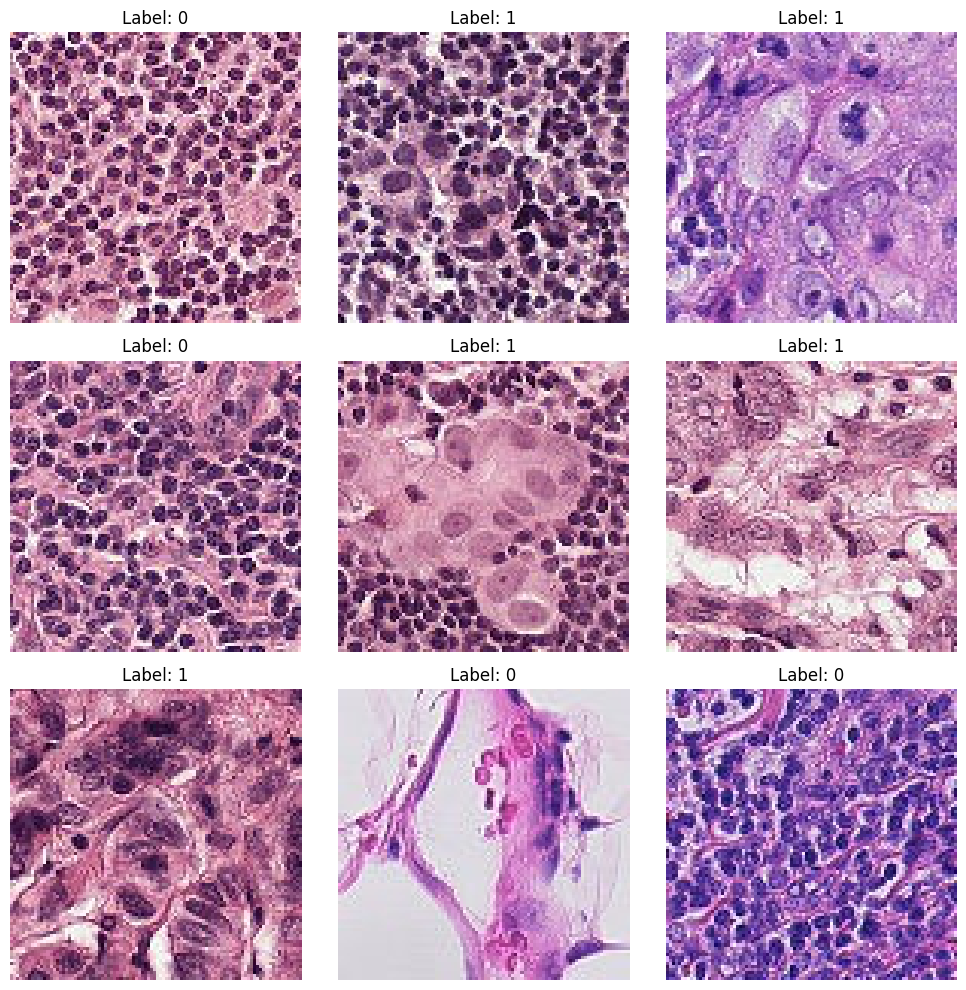

In [5]:
# Load 9 random samples
random_samples = labels_df.sample(9)

# Plot
plt.figure(figsize=(10, 10))
for i, row in enumerate(random_samples.itertuples()):
    img_path = os.path.join(train_img_dir, f"{row.id}.tif")
    image = Image.open(img_path)

    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {row.label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

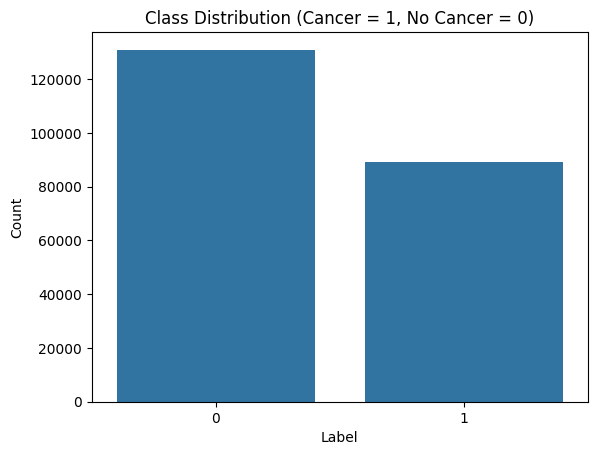

In [6]:

sns.countplot(data=labels_df, x='label')
plt.title("Class Distribution (Cancer = 1, No Cancer = 0)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


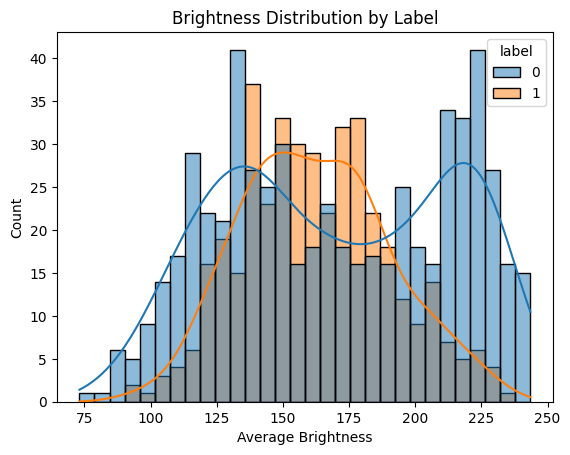

In [7]:

def compute_brightness(image_path):
    img = Image.open(image_path)
    img_array = np.array(img)
    return np.mean(img_array)

# Apply to a sample of 1000 images
sampled = labels_df.sample(1000)
sampled['brightness'] = sampled['id'].apply(lambda x: compute_brightness(os.path.join(train_img_dir, f"{x}.tif")))

sns.histplot(data=sampled, x='brightness', hue='label', bins=30, kde=True)
plt.title("Brightness Distribution by Label")
plt.xlabel("Average Brightness")
plt.show()


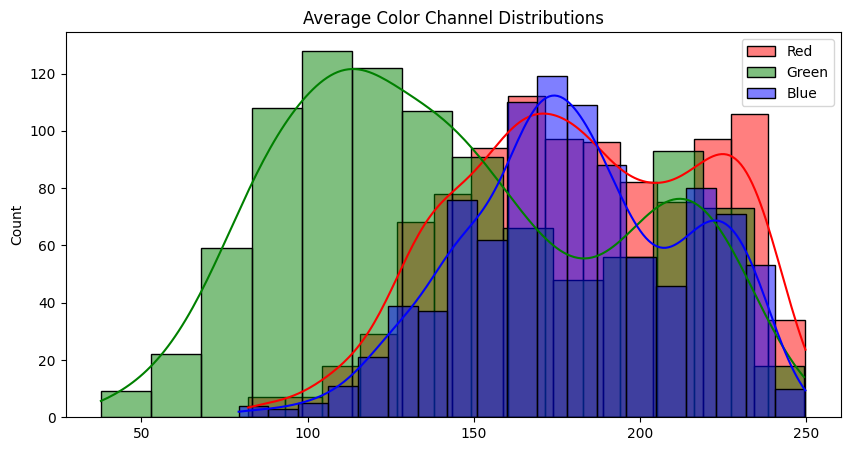

In [8]:
def avg_channels(image_path):
    img = Image.open(image_path)
    arr = np.array(img)
    return np.mean(arr[..., 0]), np.mean(arr[..., 1]), np.mean(arr[..., 2])  # R, G, B

# Sample
sampled = labels_df.sample(1000)
r_means, g_means, b_means = [], [], []

for img_id in sampled['id']:
    r, g, b = avg_channels(os.path.join(train_img_dir, f"{img_id}.tif"))
    r_means.append(r)
    g_means.append(g)
    b_means.append(b)

# Plot
plt.figure(figsize=(10, 5))
sns.histplot(r_means, color='red', label='Red', kde=True)
sns.histplot(g_means, color='green', label='Green', kde=True)
sns.histplot(b_means, color='blue', label='Blue', kde=True)
plt.title("Average Color Channel Distributions")
plt.legend()
plt.show()


In [5]:
duplicate_count = labels_df.duplicated(subset='id').sum()
print(f"Duplicate image IDs: {duplicate_count}")


Duplicate image IDs: 0


In [6]:
missing_labels = labels_df['label'].isnull().sum()
print(f"Missing labels: {missing_labels}")


Missing labels: 0


In [7]:
# Make sure all image files listed in train_labels.csv actually exist
missing_files = [
    img_id for img_id in labels_df['id']
    if not os.path.isfile(os.path.join(train_img_dir, f"{img_id}.tif"))
]

print(f"Missing image files: {len(missing_files)}")


Missing image files: 0


##Summary of Exploratory Data Analysis (EDA)

**Class Distribution:** The dataset contains two classes. The dataset is imbalanced, with approximately 25% more non-cancerous images than cancerous ones.
- Label 0 (No Cancer): ~130,000 samples
- Label 1 (Cancer): ~90,000 samples

Note: This could potentially bias the model towards predicting the majority class. However, no label imputation or class balancing has been performed yet — we plan to handle this during model training via techniques like:

**Brightness Distribution** Average brightness was calculated over a sample of images. Cancerous (label=1) images appear slightly darker on average than non-cancerous ones.

Note: Pixel-level intensity might hold predictive value, though this signal is not strong. We expect the CNNs to pick up on such patterns automatically.

**Color Channel Analysis** All three channels showed variance, with the green channel skewing slightly lower in distribution.

Note:  The model may be able to exploit the color diffeerences in tissue structure.  This is an argument for using RGB channels for input vs convering to a single grayscale channel.

**The dataset is clean, well-structured, and does not require any initial cleaning or filtering steps. This means we can move straight to preprocessing and modeling.**

### Data Cleaning
1. File Validation:
- Verified that all .tif image files listed in the dataset were present in the specified directory.
- Checked for any unreadable or corrupted images using PIL.Image.open() and discarded any that failed to load (none were found in this case).
2. Labels: Converted labels to string format
3. Image Consistency: Rescaled all pixel values to [0,1] using ImageDataGenerator(rescale=1./255).  This normalizes images


# Data Preprocessing

In order to prepare our data for processing by CNNs, we normalize our pixels  values [0,255] -> [0,1].  Essentially applying rescale=1./255.  This is necessary in order for our neural networks to generalize properly.

In [13]:
train_dir = "cancer_data/train"
df = labels_df.copy()

df["filename"] = df["id"] + ".tif"
df["label"] = df["label"].astype(str)

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col="filename",
    y_col="label",
    target_size=(50, 50),
    class_mode="binary",
    batch_size=32,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    directory=train_dir,
    x_col="filename",
    y_col="label",
    target_size=(50, 50),
    class_mode="binary",
    batch_size=32,
    shuffle=False
)


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [8]:

device_name = tf.test.gpu_device_name()
if device_name:
    print(f"GPU is available: {device_name}")
else:
    print("GPU not found. Please switch the runtime to GPU.")


GPU is available: /device:GPU:0


# Model Architecture

This project utilizes the VGGNet and ResNet as its base models for classification.  It is important to note: both VGG Net and ResNet models were trained on ~1.28 million images from ImageNet with 1,000 classes.  Our dataset is significantly smaller therefore we are attemping to find the right hyper parameters and architecture.

Single-Class Binary Classification:

- **Optimizer**: Adam
- **Loss**: Binary Crossentropy
- **Metrics**: Accuracy, Recall, F1-Score
- **Epochs**: 50 (with Early Stopping)
- **EarlyStopping**: prevents over fitting by restoring best weights.
Following the guidance of Brownlee (2020) and Heckel & Yilmaz (2020), early stopping is employed with a maximum epoch limit set to 50. This approach allows the model sufficient time to learn complex patterns, while still preventing overfitting by halting training once the validation performance stops improving, thereby promoting better generalization.

- **ReduceLROnPleateau** (factor=0.5, patience==2): Dynamically reduce learning rate. Al-Kababji et al. (2022) study on liver segmentation tasks found ReduceLROnPlateau led to faster convergence and comparable or better validation loss scores.

- **Dropout Tuning**: dropout is essential for regularizing neural networks and reducing overfitting. Studies from Srivastava et al. (2014), Pauls and Yoder (2018), and Wei et al. (2020) show that a specific value of the dropout rate (e.g., 0.2 vs. 0.3 vs. 0.5) has a smaller impact on final performance. What's more important is having a dropout layer, rather than fine-tuning we will focus on selecting a single dropout value and use that for all of our modeling and tuning.  For this study we have chosen a dropout rate of 0.5. Srivastava et al. (2014) Dropout paper in large networks, dropout rates of 0.5 are typical — especially in fully connected layers.

For our study of hyper parameters we will focus on specific architecture layouts i.e. number of layers, depth of dense layers etc.


###VGG-Style Model (Inspired by the VGGNet model [Simonyan & Zisserman, 2014])

We are treating the VGG architecture as a flexible template - it is a proven architectural pattern - we are tuning it for histopathologic cancer detection.  VGG networks are known for their deep, yet simple and uniform structure, primarily consisting of stacked 3x3 convolutional layers followed by max-pooling.

Our goal is to systematically explore how varying the number of convolutional blocks, starting filter size, and fully connected layer size affects performance on histopathologic cancer image classification.  Our

####VGG Architecture

Our VGG-style convolutional neural network is built specifically to handle binary classification on the cancer dataset.

#####Layers:
See diagram below.

**Input Layer:** Accepts an RGB image as input (dimension 50x50x3). This layers purpose is to prepare for the convolutional layers.  The image data is normalized through. preprocessing.

**Convolutional Blocks:** Composed of three layers Conv2D: Applies a set of learnable 3x3 filters to extract spatial features, ReLU Activation; Adds non-linearity for learning complex patterns, MaxPooling2D: Downsamples spatial dimensions (halves width and height), filters: doubles the number of filters to capture more complex features

**Flatten Layer:** Converts the 3D output of the last convolutional block into a 1D vector. Prepares the data for fully connected layers

**Fully Connected Layer:**Dense layer that learns to combine extracted features into class-discriminating patterns

**Dropout Layer:** Randombly deactivates a fraction of the neurons during training. This helps prevent overfitting by forcing the network to learn more robust features. We are keeping this at 0.3 for our experiment.

**Output Layer:**Final Binary classification layer outputs if the model detects cancer vs. no cancer

#####Experiment

To find the optimal configuration of our VGG-style convolutional neural network for binary classification of histopathologic cancer images, we perform a controller hyperparameter search focusing on:

1. Number of convolutional blocks (conv_blocks)
2. Starting number of filters (filters_start)
3. Size of the dense (fully connected) layer (dense_units).


| Parameter | Values Explored | Description |
|-----------|-----------------|-------|
|Convolutional Blocks| 4,5,6| Controls how many feature extraction stages are stacked. Each block consists of 2 Conv2D layers and 1 MacPooling layer. |
| Filters | 64, 256, 512 | The number of filters in the first Conv2D layer. filters double after each block |
| Dense Units | 256,512, 1024| Controls the capacity of the fully connected layer prior to output |


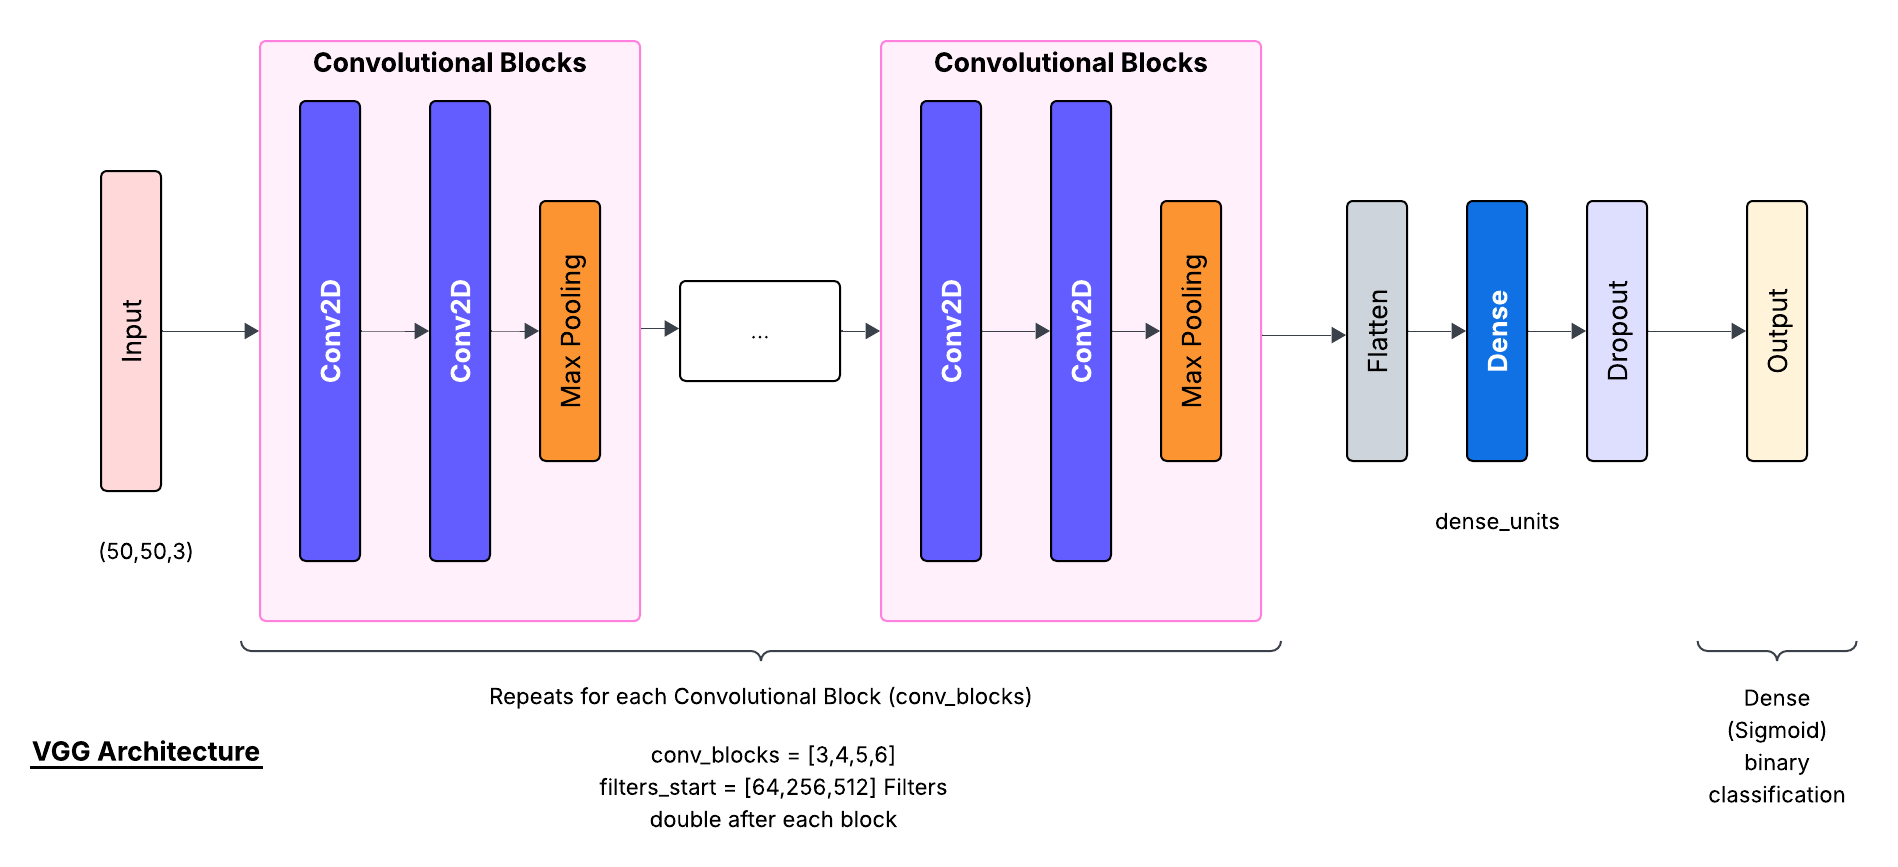

In [10]:
def build_vgg_model(
    input_shape=(50, 50, 3),
    num_classes=1,
    conv_blocks=3,
    filters_start=32,
    kernel_size=(3, 3),
    dense_units=256,
    dropout_rate=0.5
):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))

    filters = filters_start
    for _ in range(conv_blocks):
        model.add(layers.Conv2D(filters, kernel_size, padding='same', activation='relu'))
        model.add(layers.Conv2D(filters, kernel_size, padding='same', activation='relu'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        filters *= 2  # VGG Requires to double the number of clusters in each block

    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation='sigmoid'))  # binary classification

    return model


In [11]:
def clear_gpu_memory():
    K.clear_session()
    gc.collect()

    try:
        tf.compat.v1.reset_default_graph()
    except:
        pass

    print("Cleared Keras session and garbage-collected unused memory.")


In [12]:
def round_down_to_power_of_2(n, minimum=2):
    """Rounds n down to the nearest power-of-2 multiple >= minimum"""
    n = int(n)
    power = 1
    while power * 2 <= n:
        power *= 2
    return max(power, minimum)

def estimate_vgg_memory_and_batch_size(conv_blocks, filters_start, dense_units,
                                       input_shape=(50, 50, 3),
                                       bytes_per_float=4, gpu_limit_mb=40960):
    filters = filters_start
    h, w, _ = input_shape
    total_params = 0
    activations_per_example = 0

    for _ in range(conv_blocks):
        # Two Conv2D layers
        total_params += (3 * 3 * filters + 1) * filters * 2
        activations_per_example += h * w * filters * 2
        h //= 2
        w //= 2
        filters *= 2

    # Flatten + Dense
    flat_size = h * w * (filters // 2)
    total_params += (flat_size + 1) * dense_units
    activations_per_example += flat_size + dense_units

    # Output layer
    total_params += (dense_units + 1) * 1
    activations_per_example += 1

    # Estimate memory per image
    memory_params = total_params * bytes_per_float
    memory_activation = activations_per_example * bytes_per_float
    memory_gradients = memory_activation
    memory_optimizer = total_params * 2 * bytes_per_float

    total_per_image = memory_params + memory_activation + memory_gradients + memory_optimizer
    total_per_image_mb = total_per_image / (1024 ** 2)

    # Estimate max batch size
    safe_batch_size = round_down_to_power_of_2(gpu_limit_mb // total_per_image_mb)

    if safe_batch_size < 8:
        safe_batch_size = 8

    if safe_batch_size > 64:
        safe_batch_size = 64

    return {
        'conv_blocks': conv_blocks,
        'filters_start': filters_start,
        'dense_units': dense_units,
        'total_params': total_params,
        'memory_per_image_MB': total_per_image_mb,
        'recommended_batch_size': int(safe_batch_size)
    }



In [13]:
def load_existing_results(csv_path):
    """Load existing results from CSV if available."""
    if os.path.exists(csv_path):
        return pd.read_csv(csv_path,header=0)
    else:
        print(f'cant find:{csv_path}')
        return pd.DataFrame()


def has_run(config, existing_df):
    """Check if the configuration has already been evaluated."""
    if len(existing_df)==0:
      return False
    if not isinstance(existing_df, pd.DataFrame):
        return False
    match = existing_df[
        (existing_df['conv_blocks'] == config['conv_blocks']) &
        (existing_df['filters_start'] == config['filters_start']) &
        (existing_df['dense_units'] == config['dense_units']) &
        (existing_df['dropout_rate'] == config['dropout_rate'])
    ]
    return not match.empty

def save_results_to_csv(df, csv_path):
    """Save results DataFrame to CSV."""
    df.to_csv(csv_path,mode='w',header=True, index=False)

def save_history_json(history_dict, save_path):
    """Save training history as JSON."""
    with open(save_path, 'w') as f:
        json.dump(history_dict, f)

csv_results_path = f'{base_dir}results_vgg_1.csv'


In [15]:
lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

true_val_labels = val_gen.classes

base_save_dir = f'{base_dir}vgg_top_models'
os.makedirs(base_save_dir, exist_ok=True)

# Hyperparameters
conv_blocks_list = [4, 5]
filters_list = [8,16,32]
dense_units_list = [64,128,256, 512]
dropout_rate_list = [0.5]

all_combos = list(itertools.product(conv_blocks_list, filters_list, dense_units_list, dropout_rate_list))
total_combos = len(all_combos)
results = []
results_df = load_existing_results(csv_results_path)
results = results_df.values.tolist()

# Loop through all hyperparameter combinations
for idx, (conv_blocks, filters_start, dense_units, dropout_rate) in enumerate(all_combos, start=1):
    print(f"\nTraining model {idx}/{total_combos}")
    print(f"conv_blocks: {conv_blocks}, filters: {filters_start}, dense: {dense_units}, dropout: {dropout_rate}")

    config = {
        'conv_blocks': conv_blocks,
        'filters_start': filters_start,
        'dense_units': dense_units,
        'dropout_rate': dropout_rate
    }
    if has_run(config,results_df):
        print("Model already trained, skipping...")
        continue
    gc.collect()
    K.clear_session()
    tf.keras.backend.clear_session()
    clear_gpu_memory()
    start_time = time.time()

    # Build and compile model
    model = build_vgg_model(
        conv_blocks=conv_blocks,
        filters_start=filters_start,
        dense_units=dense_units,
        dropout_rate=dropout_rate
    )
    print(f"Total Parameters: {model.count_params():,}")

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    experiment_config = estimate_vgg_memory_and_batch_size(conv_blocks=conv_blocks, filters_start=filters_start, dense_units=dense_units)

    batch_size = experiment_config['recommended_batch_size']  # From your memory estimate function
    print(f"Recommended batch size: {batch_size}")

    train_gen = train_datagen.flow_from_dataframe(
        train_df,
        directory=train_dir,
        x_col="filename",
        y_col="label",
        target_size=(50, 50),
        class_mode="binary",
        batch_size=batch_size,
        shuffle=True
    )

    val_gen = val_datagen.flow_from_dataframe(
        val_df,
        directory=train_dir,
        x_col="filename",
        y_col="label",
        target_size=(50, 50),
        class_mode="binary",
        batch_size=batch_size,
        shuffle=False
    )

    # Train model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=50,
        callbacks=[lr_callback, early_stop],
        verbose=1
    )

    # Predict and evaluate
    val_preds = model.predict(val_gen)
    val_preds_labels = (val_preds > 0.5).astype(int)

    recall = recall_score(true_val_labels, val_preds_labels)
    f1 = f1_score(true_val_labels, val_preds_labels)
    cm = confusion_matrix(true_val_labels, val_preds_labels)

    # Save model
    model_filename = f'vgg_cb{conv_blocks}_f{filters_start}_d{dense_units}_dr{int(dropout_rate*100)}.h5'
    full_path = os.path.join(base_save_dir, model_filename)
    model.save(full_path)

    duration = time.time() - start_time
    print(f"Model saved to: {full_path} | Time: {duration:.2f} sec")
    print(f"Recall: {recall:.4f}, F1: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("-" * 50)
    save_history_json(history.history, os.path.join(base_save_dir, f'history_{model_filename}.json'))

    # Record results
    new_row = {
        'conv_blocks': conv_blocks,
        'filters_start': filters_start,
        'dense_units': dense_units,
        'dropout_rate': dropout_rate,
        'val_accuracy': history.history['val_accuracy'][-1],
        'val_loss': history.history['val_loss'][-1],
        'recall': recall,
        'f1_score': f1,
        'model_path': full_path,
        'train_time_sec': duration
    }
    new_row_df = pd.DataFrame([new_row])
    results_df = pd.concat([results_df, new_row_df], ignore_index=True)
    save_results_to_csv(results_df, os.path.join(base_save_dir, 'results_vgg_1.csv'))

top_models = results_df.sort_values(by='recall', ascending=False).head(10)

print("\nTop 10 models based on recall:")
print(top_models[['model_path', 'recall', 'f1_score', 'val_accuracy']])




Training model 1/24
conv_blocks: 4, filters: 8, dense: 64, dropout: 0.5
Model already trained, skipping...

Training model 2/24
conv_blocks: 4, filters: 8, dense: 128, dropout: 0.5
Model already trained, skipping...

Training model 3/24
conv_blocks: 4, filters: 8, dense: 256, dropout: 0.5
Model already trained, skipping...

Training model 4/24
conv_blocks: 4, filters: 8, dense: 512, dropout: 0.5
Model already trained, skipping...

Training model 5/24
conv_blocks: 4, filters: 16, dense: 64, dropout: 0.5
Model already trained, skipping...

Training model 6/24
conv_blocks: 4, filters: 16, dense: 128, dropout: 0.5
Model already trained, skipping...

Training model 7/24
conv_blocks: 4, filters: 16, dense: 256, dropout: 0.5
Model already trained, skipping...

Training model 8/24
conv_blocks: 4, filters: 16, dense: 512, dropout: 0.5
Model already trained, skipping...

Training model 9/24
conv_blocks: 4, filters: 32, dense: 64, dropout: 0.5
Model already trained, skipping...

Training model 1

In [14]:
def save_results_df(results_df, filename='vgg_results.csv', directory='/content/drive/MyDrive/CU/Deep Learning Projects/'):
    os.makedirs(directory, exist_ok=True)
    file_path = os.path.join(directory, filename)
    results_df.to_csv(file_path, index=False)
    print(f"Results saved to: {file_path}")



###ResNet-style Model (Inspired by ResNet [He et al. 2015])

ResNet is a deep convolutional neural network architecture that introduced skip/residual connections.

#####Architecture

**Input Layer**: Accepts 50x50 RFB histopathologic image. The image data is normalized through. preprocessing.

**Initial Layer**: a 3x3 convolutional layer followed by a BatchNorm and ReLU activation.

**Residual Blocks**: To solve the vanishing gradient problem in deep neural networks this architecture uses skip connections.  The number of residual group is defined as hyperparameters where each group uses filters, and each filter doubles for each new group.   The first block in each group downsamples using stride=2.

**Global Average Pooling**: Collapses each feature map to a single value, reducing dimensionality and prevents overfitting.

**Fully Connected Dense Layer**: Using a ReLU activation, this layer is also parametrized (dense_units) to learn the high-level combination of extracted features.

**Dropout Layer**: Randombly drops neurns during training, using a consistant value of 0.3.

**Output Layer**: Sigmoid activation to predict either cancer or no cancer.

#####Experiment

To find the optimal configuration of our ResNet-style neural network for binary classification of histopathologic cancer images, we perform a controller hyperparameter search focusing on:
1. Number of Residual Block groups
2. Starting Filtering sizes
3. Size of the dense fully connected layer



| Parameter | Values Explored | Description |
|-----------|-----------------|-------|
|Block depths (block_depths)| (2,2,2), (2,3,3), (3,4,6), (4,6,8)| Defines the number of residual blocks in each stage |
| filters_start | 32, 64, 128, 256 | The starting number of convolutional filters (doubles after each stage)|
| Dense Units (dense_units) | 256,512, 1024, 2048| Size of the final fully connected layer before output |


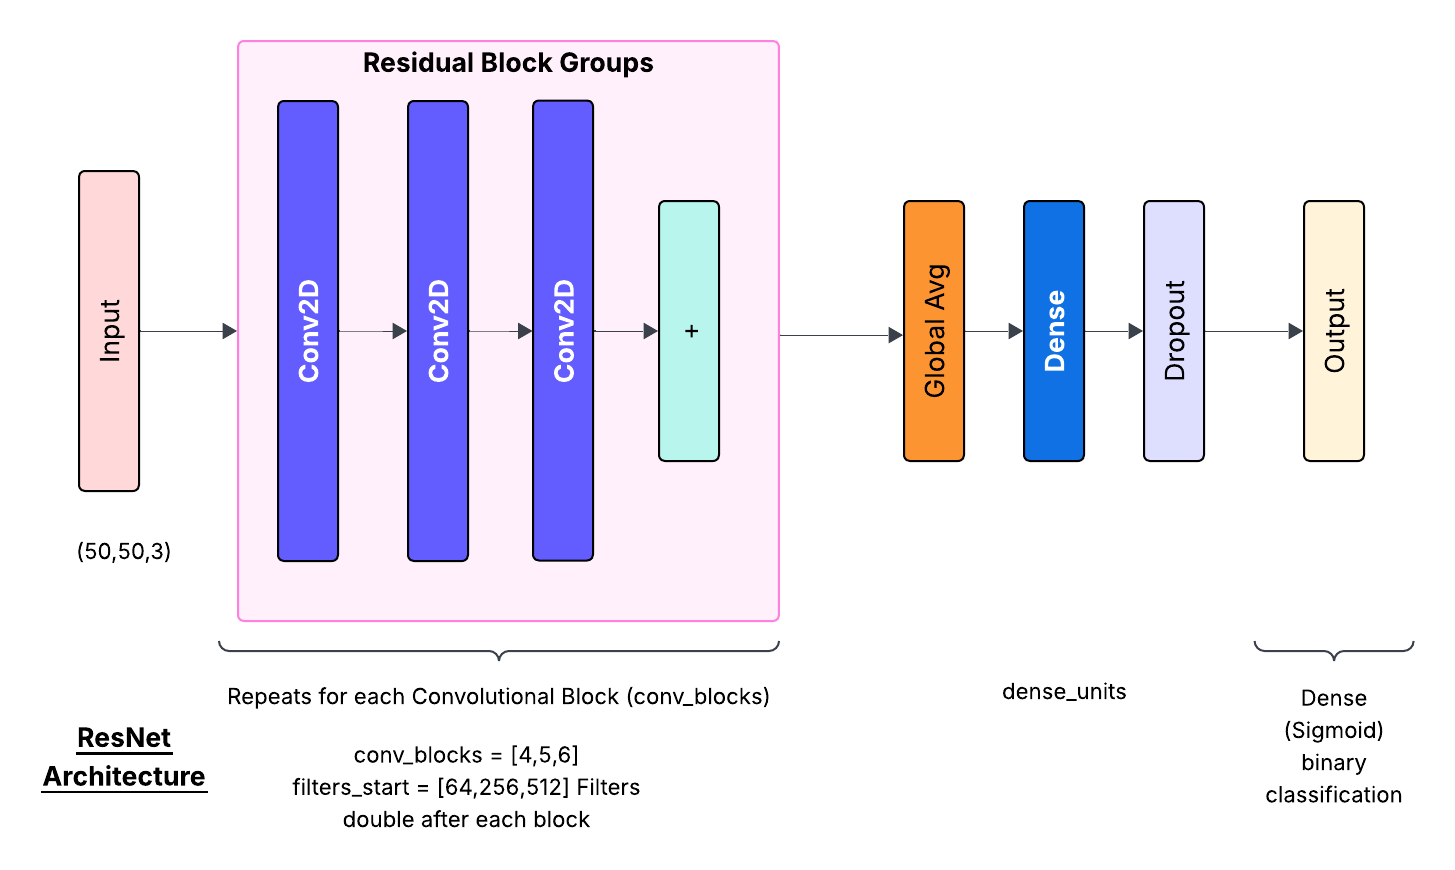

### ResNet Architecture



In [15]:
def estimate_batch_memory(model, batch_size, activation_estimate_per_sample=5e6):
    """
    Estimate total training memory for a batch.

    model: Keras model
    batch_size: Number of samples per batch
    activation_estimate_per_sample: Estimated number of floats per sample (default: ~5 million)

    Returns memory estimate in MB
    """
    param_bytes = model.count_params() * 4
    gradient_bytes = param_bytes
    optimizer_bytes = param_bytes * 2  # Adam
    activation_bytes = batch_size * activation_estimate_per_sample * 4  # Float32

    total_bytes = param_bytes + gradient_bytes + optimizer_bytes + activation_bytes
    return total_bytes /(1024**2)  # Convert to MB

def estimate_batch_size(model):
  mem_use =[]
  peak_MB = 40000
  for b in range(8,129,8):
    mem = estimate_batch_memory(model, b)
    if mem <= peak_MB:
      mem_use.append(b)
  return max(mem_use)


In [16]:

def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or x.shape[-1] != shortcut.shape[-1]:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_custom_resnet(input_shape=(50, 50, 3), num_classes=1,
                        block_depths=(2, 2, 2), filters_start=64,
                        dense_units=256, dropout_rate=0.5):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(filters_start, 3, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    filters = filters_start
    for i, num_blocks in enumerate(block_depths):
        for j in range(num_blocks):
            stride = 2 if j == 0 and i > 0 else 1
            x = residual_block(x, filters, stride=stride)
        filters *= 2

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(dense_units, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model


In [17]:
def has_run_resnet(config, existing_df):
    """Check if the configuration has already been evaluated."""
    if len(existing_df)==0:
      return False
    if not isinstance(existing_df, pd.DataFrame):
        return False
    match = existing_df[
        (existing_df['block_depths'] == str(config['block_depths'])) &
        (existing_df['filters_start'] == config['filters_start']) &
        (existing_df['dense_units'] == config['dense_units'])
    ]
    return not match.empty

In [75]:
resnet_df = load_existing_results(resnet_results_path)
config = {
        'block_depths': (2,2,3),
        'filters_start': 8,
        'dense_units': 256
    }
has_run_resnet(config,resnet_df)

False

In [18]:
results = []
save_dir = f'{base_dir}/resnet_top_models'
resnet_results_path = save_dir+'/resnet_hyperparam_search_results.csv'
os.makedirs(save_dir, exist_ok=True)
val_labels = val_gen.classes  # Only valid if shuffle=False

# Callbacks
lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

# Hyperparameter grid
all_combos = list(itertools.product(
    [(2, 2, 2), (2, 3, 3), (3, 4, 6),(4,6,8)],
    [8, 16, 32],
    [256, 512, 1024],
    [0.5]
))
total = len(all_combos)

resnet_df = load_existing_results(resnet_results_path)
# Training loop
for idx, (block_depths, filters_start, dense_units, dropout_rate) in enumerate(all_combos, start=1):
    print(f"\nTraining model {idx}/{total}")
    print(f"blocks: {block_depths}, filters: {filters_start}, dense: {dense_units}, dropout: {dropout_rate}")


    config = {
        'block_depths': block_depths,
        'filters_start': filters_start,
        'dense_units': dense_units
    }
    if has_run_resnet(config, resnet_df):
        print("Model already evaluated. Skipping...")
        continue
    K.clear_session()
    start_time = time.time()
    model = build_custom_resnet(
        block_depths=block_depths,
        filters_start=filters_start,
        dense_units=dense_units,
        dropout_rate=dropout_rate
    )

    batch_size= estimate_batch_size(model)

    train_gen = train_datagen.flow_from_dataframe(
        train_df,
        directory=train_dir,
        x_col="filename",
        y_col="label",
        target_size=(50, 50),
        class_mode="binary",
        batch_size=batch_size,
        shuffle=True
    )

    val_gen = val_datagen.flow_from_dataframe(
        val_df,
        directory=train_dir,
        x_col="filename",
        y_col="label",
        target_size=(50, 50),
        class_mode="binary",
        batch_size=batch_size,
        shuffle=False
    )

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=50,
        callbacks=[lr_callback, early_stop],
        verbose=1
    )

    preds = model.predict(val_gen, verbose=0)
    preds_labels = (preds > 0.5).astype(int)

    recall = recall_score(val_labels, preds_labels)
    f1 = f1_score(val_labels, preds_labels)
    cm = confusion_matrix(val_labels, preds_labels)

    model_name = f"resnet_b{block_depths}_f{filters_start}_d{dense_units}_dr{int(dropout_rate*100)}.h5"
    model_path = os.path.join(save_dir, model_name)
    model.save(model_path)

    duration = time.time() - start_time

    save_history_json(history.history, os.path.join(save_dir, f'history_{model_name}.json'))

    print(f"Saved: {model_path} | Time: {duration:.2f}s")
    new_row = {
        'block_depths': block_depths,
        'filters_start': filters_start,
        'dense_units': dense_units,
        'dropout_rate': dropout_rate,
        'val_accuracy': history.history['val_accuracy'][-1],
        'val_loss': history.history['val_loss'][-1],
        'recall': recall,
        'f1_score': f1,
        'model_path': model_path,
        'train_time_sec': duration
      }

    new_row_df = pd.DataFrame([new_row])
    resnet_df = pd.concat([resnet_df, new_row_df], ignore_index=True)
    save_results_to_csv(resnet_df, resnet_results_path)

# Save top 10 by recall

top10 = resnet_df.sort_values(by='recall', ascending=False).head(10)

print("\nTop 10 models based on recall:")
print(top10[['model_path', 'recall', 'f1_score', 'val_accuracy']])


Training model 1/36
blocks: (2, 2, 2), filters: 8, dense: 256, dropout: 0.5
Model already evaluated. Skipping...

Training model 2/36
blocks: (2, 2, 2), filters: 8, dense: 512, dropout: 0.5
Model already evaluated. Skipping...

Training model 3/36
blocks: (2, 2, 2), filters: 8, dense: 1024, dropout: 0.5
Model already evaluated. Skipping...

Training model 4/36
blocks: (2, 2, 2), filters: 16, dense: 256, dropout: 0.5
Model already evaluated. Skipping...

Training model 5/36
blocks: (2, 2, 2), filters: 16, dense: 512, dropout: 0.5
Model already evaluated. Skipping...

Training model 6/36
blocks: (2, 2, 2), filters: 16, dense: 1024, dropout: 0.5
Model already evaluated. Skipping...

Training model 7/36
blocks: (2, 2, 2), filters: 32, dense: 256, dropout: 0.5
Model already evaluated. Skipping...

Training model 8/36
blocks: (2, 2, 2), filters: 32, dense: 512, dropout: 0.5
Model already evaluated. Skipping...

Training model 9/36
blocks: (2, 2, 2), filters: 32, dense: 1024, dropout: 0.5
Mo

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 183s 102ms/step - accuracy: 0.8226 - loss: 0.3990 - val_accuracy: 0.8358 - val_loss: 0.4013 - learning_rate: 0.0010
Epoch 2/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 122s 88ms/step - accuracy: 0.8728 - loss: 0.3021 - val_accuracy: 0.8508 - val_loss: 0.3489 - learning_rate: 0.0010
Epoch 3/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 121s 88ms/step - accuracy: 0.8865 - loss: 0.2742 - val_accuracy: 0.8045 - val_loss: 0.5372 - learning_rate: 0.0010
Epoch 4/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8955 - loss: 0.2566
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 120s 87ms/step - accuracy: 0.8955 - loss: 0.2566 - val_accuracy: 0.8555 - val_loss: 0.3738 - learning_rate: 0.0010
Epoch 5/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 121s 88ms/step - accuracy: 0.9088 - loss: 0.2254 - val_accuracy: 0.8645 - val_loss: 0.3663 - learning_rate: 5.0000e-04
Epoch 6/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 123s 89ms/step

Saved: /content/drive/MyDrive/CU/Deep Learning Projects/resnet_top_models/resnet_b(4, 6, 8)_f8_d1024_dr50.h5 | Time: 1787.15s

Training model 31/36
blocks: (4, 6, 8), filters: 16, dense: 256, dropout: 0.5
Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 181s 102ms/step - accuracy: 0.8272 - loss: 0.3991 - val_accuracy: 0.7669 - val_loss: 0.5799 - learning_rate: 0.0010
Epoch 2/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 121s 88ms/step - accuracy: 0.8889 - loss: 0.2751 - val_accuracy: 0.8155 - val_loss: 0.4890 - learning_rate: 0.0010
Epoch 3/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 121s 88ms/step - accuracy: 0.9043 - loss: 0.2401 - val_accuracy: 0.8057 - val_loss: 0.6734 - learning_rate: 0.0010
Epoch 4/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9151 - loss: 0.2169
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 121s 88ms/step - accuracy: 0.9151 - loss: 0.2169 - val_accuracy: 0.7905 - val_loss: 0.7811 - learning_rate: 0.0010
Epoch 5/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 121s 88ms/step - accuracy: 0.9269 - loss: 0.1922 - val_accuracy: 0.8199 - val_loss: 0.4968 - learning_rate: 5.0000e-04
Epoch 6/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 123s 89ms/step - accuracy

Saved: /content/drive/MyDrive/CU/Deep Learning Projects/resnet_top_models/resnet_b(4, 6, 8)_f16_d256_dr50.h5 | Time: 2635.05s

Training model 32/36
blocks: (4, 6, 8), filters: 16, dense: 512, dropout: 0.5
Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 180s 102ms/step - accuracy: 0.8244 - loss: 0.4038 - val_accuracy: 0.7630 - val_loss: 0.7509 - learning_rate: 0.0010
Epoch 2/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 123s 89ms/step - accuracy: 0.8862 - loss: 0.2744 - val_accuracy: 0.8294 - val_loss: 0.4294 - learning_rate: 0.0010
Epoch 3/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 123s 89ms/step - accuracy: 0.9033 - loss: 0.2404 - val_accuracy: 0.8900 - val_loss: 0.2966 - learning_rate: 0.0010
Epoch 4/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 121s 88ms/step - accuracy: 0.9140 - loss: 0.2158 - val_accuracy: 0.9156 - val_loss: 0.2161 - learning_rate: 0.0010
Epoch 5/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 122s 89ms/step - accuracy: 0.9200 - loss: 0.2038 - val_accuracy: 0.8286 - val_loss: 0.4638 - learning_rate: 0.0010
Epoch 6/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9262 - loss: 0.1902
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 123s 90ms/step - accuracy: 0.

Saved: /content/drive/MyDrive/CU/Deep Learning Projects/resnet_top_models/resnet_b(4, 6, 8)_f16_d512_dr50.h5 | Time: 2044.18s

Training model 33/36
blocks: (4, 6, 8), filters: 16, dense: 1024, dropout: 0.5
Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 181s 103ms/step - accuracy: 0.8332 - loss: 0.3832 - val_accuracy: 0.7779 - val_loss: 0.9558 - learning_rate: 0.0010
Epoch 2/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 121s 88ms/step - accuracy: 0.8927 - loss: 0.2621 - val_accuracy: 0.7404 - val_loss: 2.0330 - learning_rate: 0.0010
Epoch 3/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 121s 88ms/step - accuracy: 0.9045 - loss: 0.2345 - val_accuracy: 0.8099 - val_loss: 0.5379 - learning_rate: 0.0010
Epoch 4/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 122s 89ms/step - accuracy: 0.9157 - loss: 0.2136 - val_accuracy: 0.7487 - val_loss: 0.9273 - learning_rate: 0.0010
Epoch 5/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 121s 88ms/step - accuracy: 0.9224 - loss: 0.1992 - val_accuracy: 0.8403 - val_loss: 0.4229 - learning_rate: 0.0010
Epoch 6/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 122s 89ms/step - accuracy: 0.9263 - loss: 0.1901 - val_accuracy: 0.8971 - val_loss: 0.2517 - learning_rate: 0.0010
Epoch 7/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 121s 88ms/step - accuracy:

Saved: /content/drive/MyDrive/CU/Deep Learning Projects/resnet_top_models/resnet_b(4, 6, 8)_f16_d1024_dr50.h5 | Time: 1915.39s

Training model 34/36
blocks: (4, 6, 8), filters: 32, dense: 256, dropout: 0.5
Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 185s 104ms/step - accuracy: 0.8238 - loss: 0.4067 - val_accuracy: 0.8737 - val_loss: 0.3107 - learning_rate: 0.0010
Epoch 2/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 124s 90ms/step - accuracy: 0.8904 - loss: 0.2703 - val_accuracy: 0.8606 - val_loss: 0.3303 - learning_rate: 0.0010
Epoch 3/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9110 - loss: 0.2270
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 122s 89ms/step - accuracy: 0.9110 - loss: 0.2270 - val_accuracy: 0.8058 - val_loss: 0.4891 - learning_rate: 0.0010
Epoch 4/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 122s 89ms/step - accuracy: 0.9254 - loss: 0.1943 - val_accuracy: 0.9140 - val_loss: 0.2243 - learning_rate: 5.0000e-04
Epoch 5/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 123s 90ms/step - accuracy: 0.9310 - loss: 0.1808 - val_accuracy: 0.9015 - val_loss: 0.2451 - learning_rate: 5.0000e-04
Epoch 6/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 123s 89ms/step - accu

Saved: /content/drive/MyDrive/CU/Deep Learning Projects/resnet_top_models/resnet_b(4, 6, 8)_f32_d256_dr50.h5 | Time: 1688.46s

Training model 35/36
blocks: (4, 6, 8), filters: 32, dense: 512, dropout: 0.5
Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 183s 104ms/step - accuracy: 0.8283 - loss: 0.4060 - val_accuracy: 0.7605 - val_loss: 0.8394 - learning_rate: 0.0010
Epoch 2/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 123s 89ms/step - accuracy: 0.8936 - loss: 0.2626 - val_accuracy: 0.8334 - val_loss: 0.4593 - learning_rate: 0.0010
Epoch 3/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 122s 89ms/step - accuracy: 0.9077 - loss: 0.2303 - val_accuracy: 0.8261 - val_loss: 0.4225 - learning_rate: 0.0010
Epoch 4/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 124s 90ms/step - accuracy: 0.9182 - loss: 0.2075 - val_accuracy: 0.7555 - val_loss: 1.1062 - learning_rate: 0.0010
Epoch 5/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9250 - loss: 0.1943
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 122s 89ms/step - accuracy: 0.9250 - loss: 0.1943 - val_accuracy: 0.7428 - val_loss: 1.4802 - learning_rate: 0.0010
Epoch 6/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 122s 89ms/step - accuracy: 0.

Saved: /content/drive/MyDrive/CU/Deep Learning Projects/resnet_top_models/resnet_b(4, 6, 8)_f32_d512_dr50.h5 | Time: 2538.78s

Training model 36/36
blocks: (4, 6, 8), filters: 32, dense: 1024, dropout: 0.5
Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 184s 104ms/step - accuracy: 0.8299 - loss: 0.3979 - val_accuracy: 0.8513 - val_loss: 0.3734 - learning_rate: 0.0010
Epoch 2/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 122s 89ms/step - accuracy: 0.8954 - loss: 0.2574 - val_accuracy: 0.7659 - val_loss: 0.6863 - learning_rate: 0.0010
Epoch 3/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9110 - loss: 0.2248
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 123s 89ms/step - accuracy: 0.9110 - loss: 0.2248 - val_accuracy: 0.7985 - val_loss: 0.9971 - learning_rate: 0.0010
Epoch 4/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 123s 89ms/step - accuracy: 0.9256 - loss: 0.1925 - val_accuracy: 0.9064 - val_loss: 0.2389 - learning_rate: 5.0000e-04
Epoch 5/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 123s 89ms/step - accuracy: 0.9338 - loss: 0.1738 - val_accuracy: 0.9013 - val_loss: 0.2594 - learning_rate: 5.0000e-04
Epoch 6/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accura

Saved: /content/drive/MyDrive/CU/Deep Learning Projects/resnet_top_models/resnet_b(4, 6, 8)_f32_d1024_dr50.h5 | Time: 2296.04s

Top 10 models based on recall:
                                           model_path    recall  f1_score  \
12  /content/drive/MyDrive/CU/Deep Learning Projec...  0.943949  0.903666   
34  /content/drive/MyDrive/CU/Deep Learning Projec...  0.939685  0.931790   
14  /content/drive/MyDrive/CU/Deep Learning Projec...  0.936374  0.919910   
35  /content/drive/MyDrive/CU/Deep Learning Projec...  0.934411  0.931328   
25  /content/drive/MyDrive/CU/Deep Learning Projec...  0.932952  0.928861   
3   /content/drive/MyDrive/CU/Deep Learning Projec...  0.932840  0.919071   
31  /content/drive/MyDrive/CU/Deep Learning Projec...  0.928407  0.922635   
33  /content/drive/MyDrive/CU/Deep Learning Projec...  0.924928  0.930357   
30  /content/drive/MyDrive/CU/Deep Learning Projec...  0.924648  0.921803   
20  /content/drive/MyDrive/CU/Deep Learning Projec...  0.922460  0.9124

# Model Analysis Table

The below table lists all the different model combinations which were tested.

|index|model|block\_depths|filters\_start|dense\_units|dropout\_rate|val\_accuracy|val\_loss|recall|f1\_score|train\_time\_sec|
|---|---|---|---|---|---|---|---|---|---|---|
|25|ResNet|\(3, 4, 6\)|32|512|0\.5|0\.94586980342865|0\.1589988321065902|0\.9329518038489591|0\.928860709996369|1695\.8102972507477|
|34|ResNet|\(4, 6, 8\)|32|512|0\.5|0\.9458243250846864|0\.1703183501958847|0\.9396846771026202|0\.9317903638589072|2538\.777684688568|
|35|ResNet|\(4, 6, 8\)|32|1024|0\.5|0\.9455971121788024|0\.1791926175355911|0\.934410593053919|0\.9313275919919471|2296\.0416419506078|
|8|ResNet|\(2, 2, 2\)|32|1024|0\.5|0\.9449835419654846|0\.2376573830842971|0\.8779666722773943|0\.9057652234313498|2415\.044159889221|
|7|ResNet|\(2, 2, 2\)|32|512|0\.5|0\.94102942943573|0\.2058942317962646|0\.914211973292936|0\.9323643854428932|2137\.1914451122284|
|5|ResNet|\(2, 2, 2\)|16|1024|0\.5|0\.9397341012954712|0\.1790418028831482|0\.9180833754137911|0\.9266621361422585|2356\.129402399063|
|31|ResNet|\(4, 6, 8\)|16|512|0\.5|0\.9393023252487184|0\.1766487210988998|0\.928407114402738|0\.9226351445537928|2044\.179533958435|
|30|ResNet|\(4, 6, 8\)|16|256|0\.5|0\.9372798800468444|0\.1921722590923309|0\.9246479268361106|0\.9218033337062312|2635\.0464231967926|
|4|ResNet|\(2, 2, 2\)|16|512|0\.5|0\.9312350749969482|0\.1997621953487396|0\.9087695674128936|0\.921829202356222|2130\.1539430618286|
|20|ResNet|\(3, 4, 6\)|8|1024|0\.5|0\.9295080304145812|0\.1924843192100525|0\.9224597430286708|0\.9124257727953826|2149\.0025215148926|
|12|ResNet|\(2, 3, 3\)|16|256|0\.5|0\.9290762543678284|0\.2186745405197143|0\.943948830163272|0\.9036659057338524|1531\.6366477012634|
|61|VGGNet||32|128|0\.5|0\.9269173741340636|0\.2105720341205597|0\.8757784884699545|0\.9022021848448066|2373\.463561296463|
|1|ResNet|\(2, 2, 2\)|8|512|0\.5|0\.9264174699783324|0\.1901341527700424|0\.8861583347360152|0\.9077533191562732|3104\.547380447388|
|10|ResNet|\(2, 3, 3\)|8|512|0\.5|0\.9261447787284852|0\.1935454159975052|0\.8962015373393929|0\.9106353866765484|2500\.6295154094696|
|24|ResNet|\(3, 4, 6\)|32|256|0\.5|0\.9258038997650146|0\.1936943680047989|0\.8962015373393929|0\.9143364148945304|1567\.752745628357|
|11|ResNet|\(2, 3, 3\)|8|1024|0\.5|0\.9253948330879213|0\.196309745311737|0\.8956404645682545|0\.9070659431201524|2746\.9877874851227|
|33|ResNet|\(4, 6, 8\)|32|256|0\.5|0\.9249630570411682|0\.1982885003089904|0\.92492846322168|0\.930357243636774|1688\.464208841324|
|27|ResNet|\(4, 6, 8\)|8|256|0\.5|0\.9243040680885316|0\.2087299227714538|0\.9042248779666724|0\.9059276539531746|2056\.9610340595245|
|13|ResNet|\(2, 3, 3\)|16|512|0\.5|0\.9243040680885316|0\.2403146028518676|0\.9024294450990292|0\.9178007931752687|2006\.566917657852|
|23|ResNet|\(3, 4, 6\)|16|1024|0\.5|0\.9238268136978148|0\.2153942883014679|0\.9182516972451328|0\.9233025866689232|2188\.0521097183228|
|47|VGGNet||32|512|0\.5|0\.923576891|0\.257849485|0\.895584357|0\.904721419|1882\.29619|
|9|ResNet|\(2, 3, 3\)|8|256|0\.5|0\.9230769276618958|0\.1947500854730606|0\.9045615216293552|0\.9040796298892472|2012\.3466351032257|
|0|ResNet|\(2, 2, 2\)|8|256|0\.5|0\.9219406843185424|0\.1996970772743225|0\.8743758065421086|0\.902844562887434|1855\.27124619484|
|45|VGGNet||32|128|0\.5|0\.919463694|0\.224473804|0\.898838579|0\.897252793|1881\.445203|
|44|VGGNet||32|64|0\.5|0\.919168293|0\.23468709|0\.87841553|0\.895498484|1387\.475806|
|60|VGGNet||32|64|0\.5|0\.9171684980392456|0\.2931512892246246|0\.8780227795545082|0\.8982063423733677|1888\.048560142517|
|16|ResNet|\(2, 3, 3\)|32|512|0\.5|0\.9169867038726808|0\.2809077799320221|0\.9047298434606968|0\.9185940526375754|1894\.03636097908|
|6|ResNet|\(2, 2, 2\)|32|256|0\.5|0\.9157368540763856|0\.2362897396087646|0\.8924984570498794|0\.91074086797206|1276\.6067986488342|
|59|VGGNet||16|512|0\.5|0\.9157368540763856|0\.2445247769355774|0\.9105650002805364|0\.8990139596720585|2018\.969054937363|
|32|ResNet|\(4, 6, 8\)|16|1024|0\.5|0\.9138052463531494|0\.2761605679988861|0\.8257307972844078|0\.8897016594625639|1915\.3947539329529|
|46|VGGNet||32|256|0\.5|0\.912873566|0\.273459554|0\.854008865|0\.889960826|1751\.431162|
|58|VGGNet||16|256|0\.5|0\.9127599000930786|0\.2537840902805328|0\.8769567412893452|0\.8903446311592139|1880\.0708134174347|
|63|VGGNet||32|512|0\.5|0\.9121463298797609|0\.2893730103969574|0\.8863266565673568|0\.9032534736119848|2013\.7821214199064|
|43|VGGNet||16|512|0\.5|0\.911350965|0\.277189046|0\.904842058|0\.890871427|1851\.153573|
|18|ResNet|\(3, 4, 6\)|8|256|0\.5|0\.9103738069534302|0\.2393025010824203|0\.8860461201817876|0\.9040013738622704|2529\.751774072647|
|28|ResNet|\(4, 6, 8\)|8|512|0\.5|0\.9102147221565248|0\.2433994561433792|0\.895079391797116|0\.9124864153749356|2201\.5268416404724|
|40|VGGNet||16|64|0\.5|0\.908260405|0\.240398973|0\.856982551|0\.885603293|1968\.057507|
|56|VGGNet||16|64|0\.5|0\.9074650406837464|0\.2877962291240692|0\.8936767098692701|0\.8856022907342026|2619\.8848793506622|
|57|VGGNet||16|128|0\.5|0\.906396985054016|0\.2859408557415008|0\.8560848342029961|0\.882654094235386|1877\.810276031494|
|41|VGGNet||16|128|0\.5|0\.906260669|0\.334461778|0\.863490995|0\.887415309|2220\.609721|
|21|ResNet|\(3, 4, 6\)|16|256|0\.5|0\.9055107235908508|0\.2371881753206253|0\.8656791785894631|0\.885680663586005|819\.3988780975342|
|22|ResNet|\(3, 4, 6\)|16|512|0\.5|0\.9054198265075684|0\.24507737159729|0\.8964259664478483|0\.9037020277722786|1314\.1769108772278|
|14|ResNet|\(2, 3, 3\)|16|1024|0\.5|0\.9021929502487184|0\.3127070963382721|0\.9363743477529036|0\.9199096020284424|2249\.295634508133|
|17|ResNet|\(2, 3, 3\)|32|1024|0\.5|0\.9016475677490234|0\.2801277935504913|0\.874207484710767|0\.8841286954548034|922\.2287638187408|
|42|VGGNet||16|256|0\.5|0\.900761306|0\.317195505|0\.877742243|0\.886873211|1849\.412371|
|54|VGGNet||8|256|0\.5|0\.8992841839790344|0\.2760595977306366|0\.862144420131291|0\.8734900378023477|2114\.256163835525|
|3|ResNet|\(2, 2, 2\)|16|256|0\.5|0\.8988978266716003|0\.2749619781970978|0\.9328395892947317|0\.9190713101160862|1763\.405143737793|
|29|ResNet|\(4, 6, 8\)|8|1024|0\.5|0\.898761510848999|0\.2855678200721741|0\.8618638837457219|0\.8974381444804721|1787\.1500971317291|
|39|VGGNet||8|512|0\.5|0\.897875249|0\.274820387|0\.888627055|0\.881382342|2094\.143225|
|53|VGGNet||8|128|0\.5|0\.897352576|0\.270577759|0\.854233294|0\.873043179|2256\.273911|
|37|VGGNet||8|128|0\.5|0\.896398127|0\.272766441|0\.854569938|0\.872711646|2052\.637733|
|38|VGGNet||8|256|0\.5|0\.893739343|0\.298825026|0\.819839533|0\.861429624|2498\.975683|
|52|VGGNet||8|64|0\.5|0\.88419497|0\.318079144|0\.840991977|0\.862651434|2260\.956599|
|36|VGGNet||8|64|0\.5|0\.882786036|0\.316609919|0\.84957639|0\.859730305|2487\.54875|
|19|ResNet|\(3, 4, 6\)|8|512|0\.5|0\.8741506934165955|0\.3610373735427856|0\.8913763115076025|0\.9100126016725856|1925\.1678647994995|
|26|ResNet|\(3, 4, 6\)|32|1024|0\.5|0\.8493580222129822|0\.4000422954559326|0\.9023172305448016|0\.8972828209563131|1062\.188393354416|
|15|ResNet|\(2, 3, 3\)|32|256|0\.5|0\.8332916498184204|0\.5090120434761047|0\.7608707849408068|0\.8395344518046184|801\.473147392273|
|2|ResNet|\(2, 2, 2\)|8|1024|0\.5|0\.8302465677261353|0\.4489958584308624|0\.8772933849520282|0\.8622477114811955|1036\.5089783668518|
|48|VGGNet||64|64|0\.5|0\.594977856|0\.674998581|0\.0|0\.0|779\.9611311|
|50|VGGNet||64|256|0\.5|0\.594977856|0\.675011992|0\.0|0\.0|1023\.571255|
|51|VGGNet||64|512|0\.5|0\.594977856|0\.675004303|0\.0|0\.0|1147\.426621|
|49|VGGNet||64|128|0\.5|0\.594977856|0\.674995422|0\.0|0\.0|902\.0413551|
|55|VGGNet||8|512|0\.5|0\.594977855682373|0\.675004243850708|0\.0|0\.0|1017\.2349014282228|
|62|VGGNet||32|256|0\.5|0\.594977855682373|0\.6750085353851318|0\.0|0\.0|773\.2513792514801|
|64|VGGNet||64|64|0\.5|0\.594977855682373|0\.6749979257583618|0\.0|0\.0|784\.6119768619537|

Summary Statistics:
        val_accuracy    recall  f1_score
model                                   
ResNet      0.915061  0.898662  0.908827
VGGNet      0.831613  0.661286  0.671859


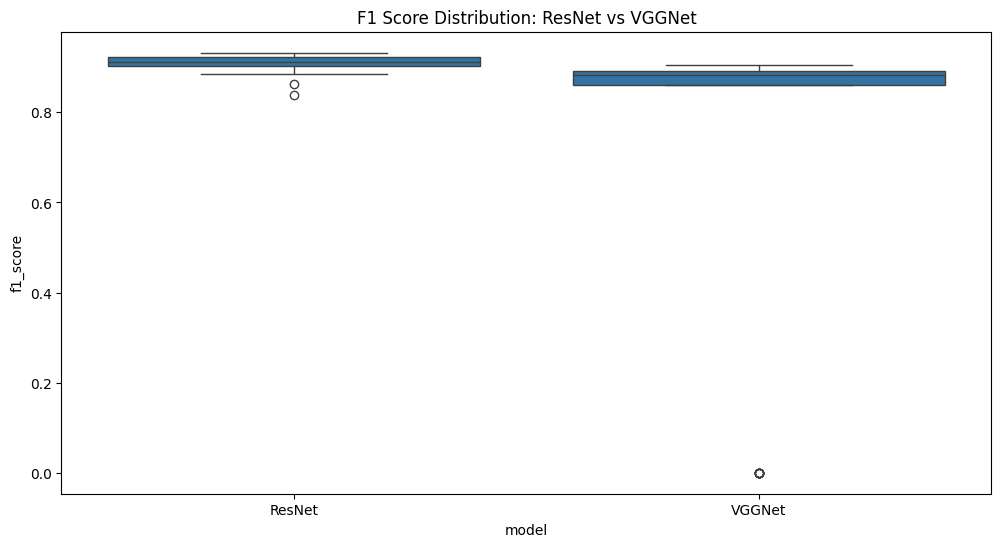

In [10]:
# Load both CSVs
resnet_path = f'{base_dir}resnet_top_models/resnet_hyperparam_search_results.csv'
vggnet_path = f'{base_dir}vgg_top_models/results_vgg_1.csv'

# Load and add a model label
resnet_df = pd.read_csv(resnet_path)
resnet_df['model'] = 'ResNet'

vggnet_df = pd.read_csv(vggnet_path)
vggnet_df['model'] = 'VGGNet'

# Standardize the columns for comparison
comparison_cols = ['model','val_accuracy', 'recall', 'f1_score']
resnet_filtered = resnet_df[comparison_cols]
vggnet_filtered = vggnet_df[comparison_cols]

# Combine the two
combined_df = pd.concat([resnet_filtered, vggnet_filtered], ignore_index=True)

# Basic summary
print("Summary Statistics:")
print(combined_df.groupby('model')[['val_accuracy', 'recall', 'f1_score']].mean())

# Optional: visualize the comparison
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df, x='model', y='f1_score')
plt.title('F1 Score Distribution: ResNet vs VGGNet')
plt.show()


In [11]:
# Read and tag model source
resnet_df = pd.read_csv(resnet_path)
resnet_df['model'] = 'ResNet'

vggnet_df = pd.read_csv(vggnet_path)
vggnet_df['model'] = 'VGGNet'

# Combine and find the best entry
combined_df = pd.concat([resnet_df, vggnet_df], ignore_index=True)
best_row = combined_df.loc[combined_df['val_accuracy'].idxmax()]

# Show best model config
print("Best model based on validation accuracy:")
print(best_row)

# Load the best model from its path
best_model_path = best_row['model_path']
print(f"Loading model from: {best_model_path}")
best_model = load_model(best_model_path)

# Optional: summary of the loaded model
best_model.summary()


Best model based on validation accuracy:
block_depths                                              (3, 4, 6)
filters_start                                                    32
dense_units                                                     512
dropout_rate                                                    0.5
val_accuracy                                                0.94587
val_loss                                                   0.158999
recall                                                     0.932952
f1_score                                                   0.928861
model_path        /content/drive/MyDrive/CU/Deep Learning Projec...
train_time_sec                                          1695.810297
model                                                        ResNet
conv_blocks                                                     NaN
Name: 25, dtype: object
Loading model from: /content/drive/MyDrive/CU/Deep Learning Projects/resnet_top_models/resnet_b(3, 4, 6)_f32_d512_dr50.

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50, 50, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 50, 50,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 50, 50,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 50, 50,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 50, 50,    │      9,248 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 50, 50,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 50, 50,    │      9,248 │ re_lu_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 50, 50,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 50, 50,    │          0 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 50, 50,    │      9,248 │ re_lu_2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 50, 50,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 50, 50,    │      9,248 │ re_lu_3[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 50, 50,    │          0 │ batch_normalizat

 Total params: 2,117,507 (8.08 MB)

 Trainable params: 2,112,577 (8.06 MB)

 Non-trainable params: 4,928 (19.25 KB)

 Optimizer params: 2 (12.00 B)

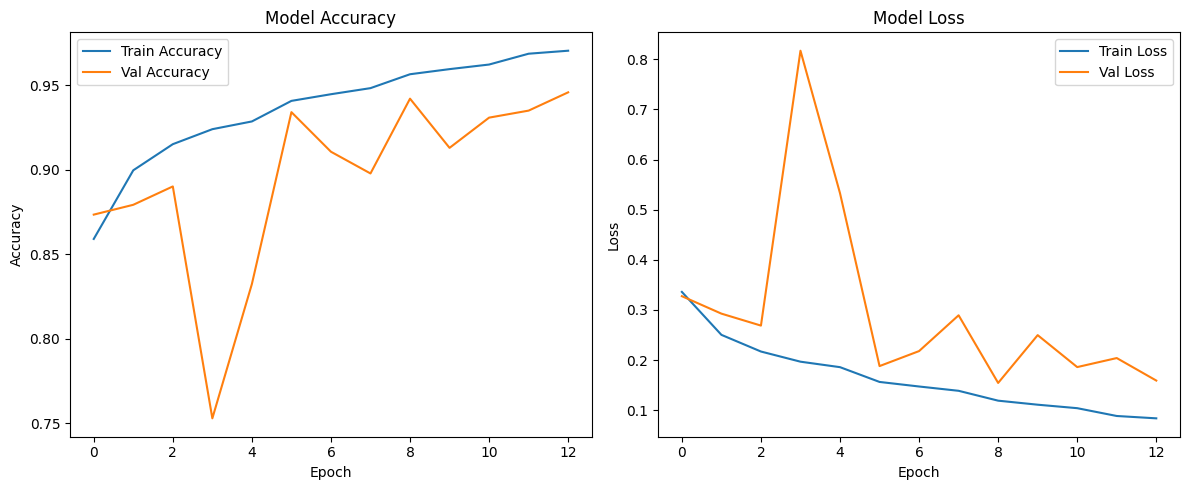

In [18]:
history_path = "/content/drive/MyDrive/CU/Deep Learning Projects/resnet_top_models/history_resnet_b(3, 4, 6)_f32_d512_dr50.h5.json"
with open(history_path, 'r') as f:
    history_dict = json.load(f)

history_df = pd.DataFrame(history_dict)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training vs validation loss
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Selected Model

Conducting a hyperparameter search comparing ResNet and VGGNet varients, evaluating models based on validation accuracy, recall, and F1 Score.  Validation Accuracy measures overall prediction correctness on unseen validation data.  Recall is important for medical tasks - tells us how well the model detects postive cases, and F1 score which balances precision and recall.

ResNet model outperformed the VGGNet type model across all key metrics. Recall and F1 score are significantly higher - this indicates a better detection of positive cases.  The selected model looks to be best selected based on hyper paramters.

ResNet Architecture: with configuration
- block_depths: (3,4,6)
- filters_start: 32
- dense_units: 512
- Total Parameters: ~2.1 million


####Model Accuracy Plot
- Training accuracy improves steadily, reaching ~97%.
- Validation accuracy fluctuates more, but also shows an overall upward trend, peaking around ~94.5%.
- The model is learning well on the training data — no signs of underfitting.
- The validation accuracy fluctuates but ultimately improves, indicating good generalization.
- The recovery after the early dip suggests that learning rate scheduling or regularization may be helping the model stabilize.

####Model Loss Plot
- The spike in validation loss (epoch 3-4) might be due to a bad weight update, batch variance, or early instability — possibly resolved by learning rate reduction or early stopping.
- The consistent gap between training and validation loss could be an early sign of minor overfitting, but not alarming given the validation accuracy remains strong.



In [14]:
test_dir = "cancer_data/test"

# Create a dataframe of test image filenames (no labels)
test_filenames = os.listdir(test_dir)
test_df = pd.DataFrame({'filename': test_filenames})

# Use ImageDataGenerator to load images (rescale them)
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    directory=test_dir,
    x_col='filename',
    y_col=None,
    target_size=(50, 50),
    batch_size=64,
    shuffle=False,  # Important to keep order for matching IDs
    class_mode=None
)

pred_probs = best_model.predict(test_gen, verbose=1)

submission_df = pd.DataFrame({
    'id': [fname.replace('.tif', '') for fname in test_df['filename']],
    'label': pred_probs.flatten()
})


# Preview
print(submission_df.head())
submission_path = f"{base_dir}submission_resnet.csv"
submission_df.to_csv(submission_path, index=False)
print(f"Submission saved to: {submission_path}")

Found 57458 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 275s 305ms/step
                                         id     label
0  68d94efa9ccebc46ffb2cb4127c6e43702c2860b  0.036798
1  b6857075ab9f6bbdd6801886e94b9a452f2c1e83  0.000143
2  d6830706b35b9db36b3a9923f653dddad58c75ba  0.859687
3  8026c3123cc270ef2c5d35fcba1122f37dfb20f9  0.999701
4  a80a447cb9ceb804ba58326d4604c1a95ee1ab78  0.991016
Submission saved to: /content/drive/MyDrive/CU/Deep Learning Projects/submission_resnet.csv


#Kaggle Model Submission

The searched model was submited to kaggle for evaluation and achieved a public score of 0.9532 and private score of 0.8940.

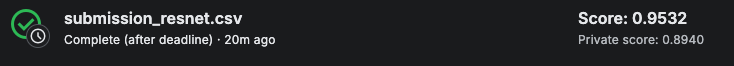

# Challanges

**GPU Memory Constraints and Batch Size Tuning**

One of the most significant challenges encountered during this project was managing GPU memory limitations; when training deeper ResNet and VGGNet architectures. The models were developed and trained on a Google Colab Pro instance with an NVIDIA A100 GPU, memory usage became a bottleneck when increasing depth, filter sizes, and dense layer units.

As the number of layers and parameters grew, so did the memory required per batch, especially during backpropagation.  To overcome this, we implemented a memory estimation strategy: calculate the approximate number of trainable parameters using model.count_params() or in the case of VGGNet esimate based on what we know of the model.  Use this estimate as a guide to select maximum batch size. This approach allowed dynamic batch sizeing: ranging from 8 to 64.


# Next Steps

1. Dropout Tuning or L2 Regularization
2. Adjust early stopping for longer training times
3. Preprocessing of Image data

# Conclusion

This project demonstrated deep convolutional neural networks in the early detection of cancer using histopathologic image data. Through extensive experimentation and model tuning, we compared two prominent architectures — VGGNet and ResNet — across a range of hyperparameters. Our findings showed that ResNet models significantly outperformed VGGNet in terms of validation accuracy, recall, and F1-score, highlighting the advantage of residual connections in training deeper and more accurate models.

Throughout the process, we encountered and addressed several real-world challenges, including GPU memory limitations and the need to balance model complexity with computational efficiency. By incorporating memory estimation techniques, careful data preprocessing, and systematic hyperparameter tuning, we were able to train models that achieved high performance while remaining resource-aware.

While our best-performing ResNet configuration achieved a validation accuracy of 94.6% and a recall of over 93%, this work lays the foundation for further improvement. Future directions may include incorporating transfer learning, advanced data augmentation, and ensembling strategies.

Overall, this study reinforces the power of deep learning in medical imaging and sets the stage for developing robust, scalable, and interpretable models for cancer detection.

# References

Kaggle. (2018). Histopathologic Cancer Detection. Retrieved from https://www.kaggle.com/competitions/histopathologic-cancer-detection

Simonyan, K., & Zisserman, A. (2015). Very Deep Convolutional Networks for Large-Scale Image Recognition. arXiv preprint arXiv:1409.1556. Retrieved from https://arxiv.org/abs/1409.1556

Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: A simple way to prevent neural networks from overfitting. Journal of Machine Learning Research, 15(1), 1929–1958. Retrieved from https://jmlr.org/papers/v15/srivastava14a.html

Pauls, J., & Yoder, L. (2018). Determining Optimum Drop-out Rate for Neural Networks. Midwest Instruction and Computing Symposium (MICS). Retrieved from https://micsymposium.org/mics2018/proceedings/MICS_2018_paper_27.pdf

Wei, C., Ma, T., & Woodruff, D. P. (2020). The Implicit and Explicit Regularization Effects of Dropout. arXiv preprint arXiv:2002.12915. Retrieved from https://arxiv.org/abs/2002.12915

Brownlee, J. (2020). Use Early Stopping to Halt the Training of Neural Networks At the Right Time. Machine Learning Mastery. Retrieved from https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

Heckel, R., & Yilmaz, F. F. (2020). Early Stopping in Deep Networks: Double Descent and How to Eliminate it. arXiv preprint arXiv:2007.10099. Retrieved from https://arxiv.org/abs/2007.10099

Al-Kababji, A., Kang, M., & Ghesu, F. C. (2022). A comparative study of learning rate schedules for liver segmentation using deep learning. arXiv preprint arXiv:2202.06373. Retrieved from https://arxiv.org/abs/2202.06373

Mahmoud, O. S. (2021). Sports Image Classification Using VGGNet. GitHub repository. https://github.com/ossaamamahmoud/Sports-Image-Classification